<a href="https://colab.research.google.com/github/rmastand/FETA/blob/main/notebooks/Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2025 Francois Lanusse

Licensed under the Apache License, Version 2.0 (the "License");

In [1]:
# Installing the AION code and all its dependencies
!pip install --quiet --upgrade huggingface_hub polymathic-aion

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 503.8/503.8 kB 35.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.0/89.0 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 3.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
transformers 4.57.1 requires huggingface-hub<1.0,>=0.34.0, but you have huggingface-hub 1.0.1 which is incompatible.



---
### 🔽 Downloading demo datasets

In [2]:
# Downloading a bunch of data (takes a few minutes)
!wget https://users.flatironinstitute.org/~flanusse/provabgs_legacysurvey_eval_v2.fits

--2025-11-04 19:19:00--  https://users.flatironinstitute.org/~flanusse/provabgs_legacysurvey_eval_v2.fits
Resolving users.flatironinstitute.org (users.flatironinstitute.org)... 158.106.193.205
Connecting to users.flatironinstitute.org (users.flatironinstitute.org)|158.106.193.205|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2415211200 (2.2G) [application/octet-stream]
Saving to: ‘provabgs_legacysurvey_eval_v2.fits’

provabgs_legacysurv 100%[===================>]   2.25G  16.0MB/s    in 2m 34s  

2025-11-04 19:21:36 (14.9 MB/s) - ‘provabgs_legacysurvey_eval_v2.fits’ saved [2415211200/2415211200]



In [7]:
from aion.codecs import CodecManager

# Instantiate the manager
codec_manager = CodecManager(device="cuda")


In [8]:
import torch
from aion.model import AION

# Disable gradients for this notebook
torch.set_grad_enabled(False)

# Importing model
model = AION.from_pretrained("polymathic-ai/aion-base").to("cuda").eval()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.27G [00:00<?, ?B/s]

In [9]:
from tqdm import tqdm
from astropy.table import Table

from aion.modalities import (
    LegacySurveyImage,
    DESISpectrum,
    LegacySurveyFluxG,
    LegacySurveyFluxR,
    LegacySurveyFluxI,
    LegacySurveyFluxZ,
    Z,
)

# Loading the data
data = Table.read("provabgs_legacysurvey_eval_v2.fits")


# Define utility function to create modalities from the table
def format_data_modalities(data, device="cuda"):
    """Formats the input data into modality objects."""

    # Helper function
    def to_tensor(data_array, dtype="float32"):
        return torch.tensor(np.array(data_array).astype(dtype), device=device)

    # Create image modality
    image = LegacySurveyImage(
        flux=to_tensor(data["legacysurvey_image_flux"]),
        bands=["DES-G", "DES-R", "DES-I", "DES-Z"],
    )

    # Create spectrum modality
    spectrum = DESISpectrum(
        flux=to_tensor(data["desi_spectrum_flux"]),
        ivar=to_tensor(data["desi_spectrum_ivar"]),
        mask=to_tensor(data["desi_spectrum_mask"], dtype="bool"),
        wavelength=to_tensor(data["desi_spectrum_lambda"]),
    )

    # Create flux modalities
    g = LegacySurveyFluxG(value=to_tensor(data["legacysurvey_FLUX_G"]))
    r = LegacySurveyFluxR(value=to_tensor(data["legacysurvey_FLUX_R"]))
    i = LegacySurveyFluxI(value=to_tensor(data["legacysurvey_FLUX_I"]))
    z = LegacySurveyFluxZ(value=to_tensor(data["legacysurvey_FLUX_Z"]))

    return image, spectrum, g, r, i, z

Now we can format one batch of data:

In [10]:
# Create modalities from a batch of data
batch_size = 32
image, spectrum, g, r, i, z = format_data_modalities(data[:batch_size])

And we can feed to the AION model any set of input modalities. We can request any output, but here we simply query for the tokenized redshift modality.

This will output an array of logits for the value of the redshift token. Plotting that array of probilities gives us an estimate of the redsfhit distribution for that object:

## Step IV: Where the real magic is: Embeddings!


Despite being trained on a number of generative modeling tasks, AION could never be trained end-to-end on all tasks of potential interest to astronomers.

We are lucky however that the model can trivially be used to build downstream tasks just from having access to the encoder embeddings:

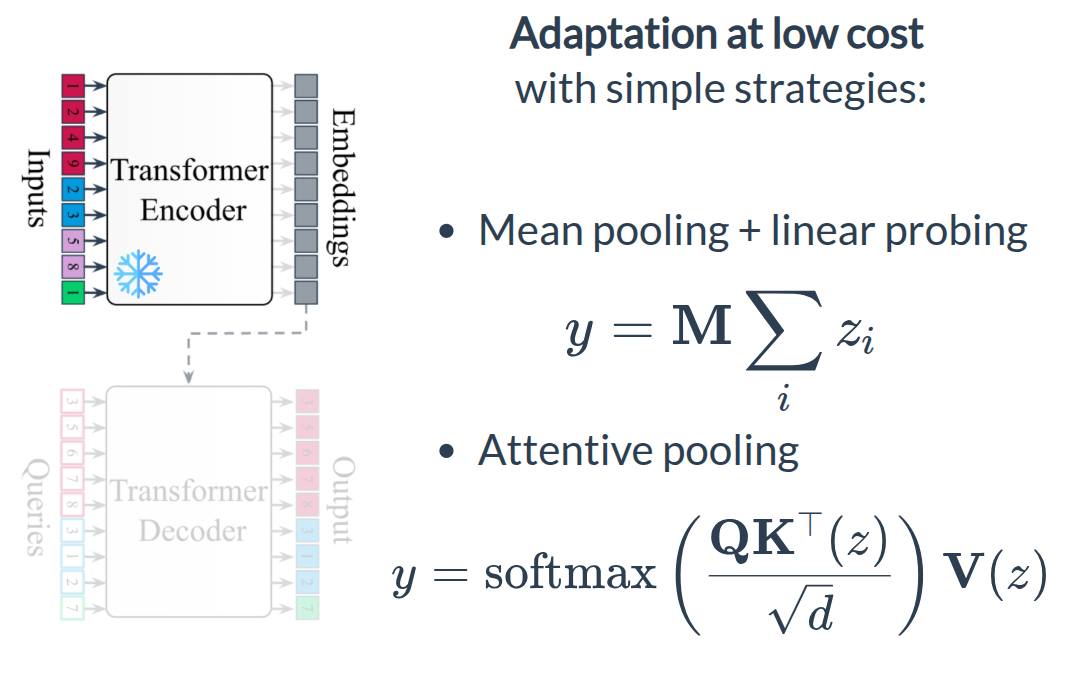

In this approach, we do not fine tune AION-1 further for a new task, we simply extract the embeddings, and build a simple prediction head on top.


First, let's learn a new AION function `AION.encode`: this will take a dictionary of tokens(from any combination of modalities), and output embeddings:

In [11]:
embeddings = model.encode(tokens, num_encoder_tokens=600)

print("Shape of computed embeddings", embeddings.shape)

NameError: name 'tokens' is not defined

Now we can compute embeddings for all our dataset. Note that in the code below we compute several kind of embeddings, with the only difference being which set of modality we use as the input:

- `model.encode(codec_manager.encode(image))`
- `model.encode(codec_manager.encode(spectrum))`
- `model.encode(codec_manager.encode(image, spectrum, g,r,i,z))`

This will allow us to test how informative these embeddings are as a function of what modalities are provided as an input.


For the purpose of this tutorial we are going to use the simplest vector embedding method: **mean pooling**.

In [23]:
batch_size = 64
im_embeddings = []
sp_embeddings = []
all_embeddings = []

# Loop through the table in batches
for i in tqdm(range(0, 1, batch_size)):
    batch_data = data[i : i + batch_size]

    # Format data into modalities for the current batch
    image, spectrum, g, r, i, z = format_data_modalities(batch_data, device="cuda")

     # Helper function
    def to_tensor(data_array, dtype="float32"):
        return torch.tensor(np.array(data_array).astype(dtype), device="cuda")


    flux=to_tensor(batch_data["legacysurvey_image_flux"])
    print(flux.size())
    for i in range(4):
      array = flux[:,i,:,:].reshape(-1,)
      print(i, torch.mean(array), torch.std(array))


    spectrum =to_tensor(data["desi_spectrum_flux"])
    print(torch.mean(spectrum), torch.std(spectrum))
    print(spectrum.size())


    # Compute embeddings using the AION model
    im_embeddings.append(
        model.encode(codec_manager.encode(image), num_encoder_tokens=600).mean(axis=1)
    )

    sp_embeddings.append(
        model.encode(codec_manager.encode(spectrum), num_encoder_tokens=300).mean(
            axis=1
        )
    )

    all_embeddings.append(
        model.encode(
            codec_manager.encode(image, g, r, i, z), num_encoder_tokens=900
        ).mean(axis=1)
    )

# Concatenate the embeddings from all batches
im_embeddings = torch.cat(im_embeddings, dim=0).cpu().numpy()
sp_embeddings = torch.cat(sp_embeddings, dim=0).cpu().numpy()
all_embeddings = torch.cat(all_embeddings, dim=0).cpu().numpy()

print(f"Successfully processed {len(data)} images in batches of {batch_size}.")
print(f"Embeddings shape: {all_embeddings.shape}")

  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([64, 4, 96, 96])
0 tensor(0.0032, device='cuda:0') tensor(0.0829, device='cuda:0')
1 tensor(0.0070, device='cuda:0') tensor(0.1411, device='cuda:0')
2 tensor(0.0099, device='cuda:0') tensor(0.1633, device='cuda:0')
3 tensor(0.0119, device='cuda:0') tensor(0.1609, device='cuda:0')
tensor(3.0287, device='cuda:0') tensor(4.1162, device='cuda:0')
torch.Size([3815, 7800])


  0%|          | 0/1 [00:01<?, ?it/s]


ModalityTypeError: Modality Tensor does not have a token_key attribute

Excellent, now let's see a few use cases.

### 🔎 Similarity Search in Embedding Space

In this section, we perform a **similarity search** to find galaxies that are most similar to a selected query image, based on their positions in the learned **embedding space**.

We use **cosine similarity** to measure how close each image embedding is to the embedding of the selected query image. This allows us to identify objects that share similar high-level visual or morphological features, as captured by the embedding model.

The steps are:
- Select a query galaxy image.
- Compute cosine similarity between its embedding and all others in the dataset.
- Retrieve and display the **top 16 most similar images** (excluding the query itself).

This technique enables **fast, content-based retrieval** from large image datasets, and can be a powerful tool for exploratory data analysis and serendipitous discovery.


In [ ]:
# @title [Run Me] Similarity by image alone
from sklearn.metrics.pairwise import cosine_similarity
from ipywidgets import interact

query_images = data["legacysurvey_image_rgb"][:16]
selected_index = {"value": 0}  # Use a mutable dict


# Define the display function
def show_query_image(index):
    selected_index["value"] = index
    img = query_images[index]
    img_hwc = img

    plt.figure(figsize=(3, 3))
    plt.imshow(img_hwc)
    plt.axis("off")
    plt.title(f"Selected Query Image: {index}")
    plt.show()

    query_index = selected_index["value"]

    similarity = cosine_similarity(
        im_embeddings[query_index].reshape(1, -1), im_embeddings
    ).squeeze()

    # Get indices of all embeddings
    all_indices = np.arange(len(im_embeddings))
    # Sort by similarity in descending order
    sorted_indices = all_indices[np.argsort(similarity)[::-1]]

    top_n = 16
    top_indices = sorted_indices[:top_n]

    # Retrieve the images corresponding to these top indices
    top_images = data["legacysurvey_image_rgb"][top_indices]

    # Draw the postage stamps
    fig, axes = plt.subplots(4, 4, figsize=(8, 8))  # Create a 4x4 grid for 16 images
    axes = axes.flatten()

    for i in range(min(len(top_images), 16)):
        img = top_images[i]
        axes[i].imshow(img)
        axes[i].axis("off")
        # Optional: Add title indicating the index of the retrieved image in the original dataset
        axes[i].set_title(f"Obj {top_indices[i]}", fontsize=8)

    plt.tight_layout()
    plt.suptitle(f"Top {top_n} Most Similar Objects to Obj {query_index}", y=1.02)
    plt.show()


# Use interact to create a dropdown or slider
interact(show_query_image, index=(0, len(query_images) - 1));

In [ ]:
# @title [Run Me] Similarity by spectrum alone

query_images = data["legacysurvey_image_rgb"][:16]
selected_index = {"value": 0}  # Use a mutable dict


# Define the display function
def show_query_image(index):
    selected_index["value"] = index  # Store the selection
    img = query_images[index]
    img_hwc = img

    plt.figure(figsize=(3, 3))
    plt.imshow(img_hwc)
    plt.axis("off")
    plt.title(f"Selected Query Image: {index}")
    plt.show()

    query_index = selected_index["value"]

    similarity = cosine_similarity(
        sp_embeddings[query_index].reshape(1, -1), sp_embeddings
    ).squeeze()

    # Get indices of all embeddings
    all_indices = np.arange(len(sp_embeddings))
    # Sort by similarity in descending order
    sorted_indices = all_indices[np.argsort(similarity)[::-1]]

    top_n = 16
    top_indices = sorted_indices[:top_n]

    # Retrieve the images corresponding to these top indices
    top_images = data["legacysurvey_image_rgb"][top_indices]

    # Draw the postage stamps
    fig, axes = plt.subplots(4, 4, figsize=(8, 8))  # Create a 4x4 grid for 16 images
    axes = axes.flatten()

    for i in range(min(len(top_images), 16)):
        img = top_images[i]
        img_hwc = img
        axes[i].imshow(img_hwc)
        axes[i].axis("off")
        # Optional: Add title indicating the index of the retrieved image in the original dataset
        axes[i].set_title(f"Obj {top_indices[i]}", fontsize=8)

    plt.tight_layout()
    plt.suptitle(f"Top {top_n} Most Similar Objects to Obj {query_index}", y=1.02)
    plt.show()


# Use interact to create a dropdown or slider
interact(show_query_image, index=(0, len(query_images) - 1));

### 📈 Redshift Estimation with k-Nearest Neighbors (k-NN) Regression

In this section, we use a **k-Nearest Neighbors (k-NN) regressor** to predict galaxy redshifts directly from their image embeddings.

The idea is simple: for a given embedding, find its `k` closest neighbors in the embedding space and return the **average redshift** of those neighbors. This method relies on the assumption that similar embeddings (i.e., similar galaxies) should have similar redshifts.

Here’s what we do:
- Split the dataset into training and testing sets.
- Train a `KNeighborsRegressor` using the training embeddings and redshifts.
- Predict redshifts for the test set.
- Visualize the performance by plotting **true vs. predicted redshifts**.

This provides a quick baseline and helps assess how well the learned embedding space captures redshift-related information.


In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [ ]:
# Prepare data for k-NN regression
X_train, X_test, y_train, y_test = train_test_split(
    sp_embeddings, data["desi_Z"], test_size=0.2, random_state=42
)

And here is all that is required to build a new estimator 🤯:

In [ ]:
knn_regressor = KNeighborsRegressor(n_neighbors=2)
knn_regressor.fit(X_train, y_train)

# Predict redshift on the test set
y_pred = knn_regressor.predict(X_test)

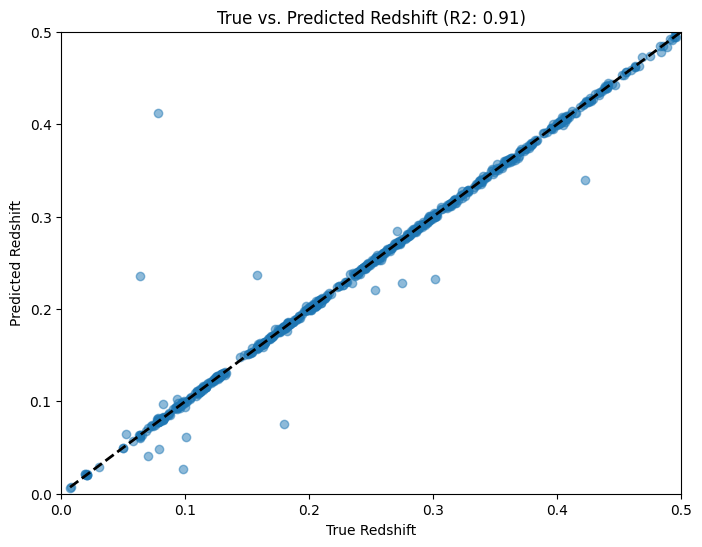

In [ ]:
# Calculate the R2 score
r2 = r2_score(y_test, y_pred)

# Plot true vs predicted redshift
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("True Redshift")
plt.ylabel("Predicted Redshift")
plt.title(f"True vs. Predicted Redshift (R2: {r2:.2f})")  # Add R2 score to the title
plt.plot(
    [y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "k--", lw=2
)  # Add a diagonal line
plt.xlim(0, 0.5)
plt.ylim(0, 0.5)
plt.show()